# Lab 2: Debug a Broken Vanilla GAN (find 12+ issues)

In [5]:
import torch, torchvision, torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

In [6]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])  # BUG normalize
loader=DataLoader(torchvision.datasets.MNIST('./data',True,download=True,transform=transform),batch_size=256,shuffle=True,num_workers=2,pin_memory=True)
z_dim=100; g_lr=2e-2; d_lr=2e-5

In [7]:
class D(nn.Module):
    def __init__(self):
        super().__init__(); self.net=nn.Sequential(
            nn.Conv2d(1,32,4,2,1),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(32,64,4,2,1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2,True),
            nn.Conv2d(64,1,7,1,0))
    def forward(self,x):
      return self.net(x).view(x.size(0),1)
class G(nn.Module):
    def __init__(self):
        super().__init__(); self.net=nn.Sequential(
            nn.ConvTranspose2d(z_dim,256,7,1,0),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256,128,4,2,1),
            nn.BatchNorm2d(128),nn.ReLU(True),
            nn.ConvTranspose2d(128,1,4,2,1),
            nn.Tanh())
    def forward(self,z):
       z=z.view(z.size(0),z_dim,1,1);
       return self.net(z)
Dnet=D().to(device); Gnet=G().to(device)
crit=nn.BCEWithLogitsLoss();
opt_d=torch.optim.Adam(Dnet.parameters(),lr=d_lr,betas=(0.9,0.999));
opt_g=torch.optim.Adam(Gnet.parameters(),lr=g_lr,betas=(0.9,0.999))

In [14]:
from tqdm import tqdm

num_epochs = 20

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    for real,_ in tqdm(loader):
        real=real.to(device); b=real.size(0)

        opt_d.zero_grad()
        z=torch.randn(b,z_dim,device=device); fake=Gnet(z)
        loss_d_real=crit(Dnet(real),torch.ones(b,1,device=device))
        loss_d_fake=crit(Dnet(fake.detach()),torch.zeros(b,1,device=device))
        loss_d=(loss_d_real+loss_d_fake)/2
        loss_d.backward()
        opt_d.step()

        opt_g.zero_grad()
        z=torch.randn(b,z_dim,device=device); fake=Gnet(z)
        loss_g=crit(Dnet(fake),torch.ones(b,1,device=device))
        loss_g.backward()
        opt_g.step()

print('Now fix all the issues.')

Epoch 1/20


100%|██████████| 235/235 [00:12<00:00, 18.51it/s]


Epoch 2/20


100%|██████████| 235/235 [00:12<00:00, 18.59it/s]


Epoch 3/20


100%|██████████| 235/235 [00:13<00:00, 18.06it/s]


Epoch 4/20


100%|██████████| 235/235 [00:12<00:00, 18.09it/s]


Epoch 5/20


100%|██████████| 235/235 [00:13<00:00, 17.63it/s]


Epoch 6/20


100%|██████████| 235/235 [00:13<00:00, 17.81it/s]


Epoch 7/20


100%|██████████| 235/235 [00:12<00:00, 18.09it/s]


Epoch 8/20


100%|██████████| 235/235 [00:13<00:00, 17.75it/s]


Epoch 9/20


100%|██████████| 235/235 [00:13<00:00, 17.43it/s]


Epoch 10/20


100%|██████████| 235/235 [00:13<00:00, 17.22it/s]


Epoch 11/20


100%|██████████| 235/235 [00:12<00:00, 18.14it/s]


Epoch 12/20


100%|██████████| 235/235 [00:12<00:00, 18.42it/s]


Epoch 13/20


100%|██████████| 235/235 [00:13<00:00, 18.02it/s]


Epoch 14/20


100%|██████████| 235/235 [00:13<00:00, 17.39it/s]


Epoch 15/20


100%|██████████| 235/235 [00:13<00:00, 17.77it/s]


Epoch 16/20


100%|██████████| 235/235 [00:13<00:00, 17.55it/s]


Epoch 17/20


100%|██████████| 235/235 [00:14<00:00, 16.62it/s]


Epoch 18/20


100%|██████████| 235/235 [00:13<00:00, 17.12it/s]


Epoch 19/20


100%|██████████| 235/235 [00:13<00:00, 17.31it/s]


Epoch 20/20


100%|██████████| 235/235 [00:13<00:00, 17.81it/s]

Now fix all the issues.


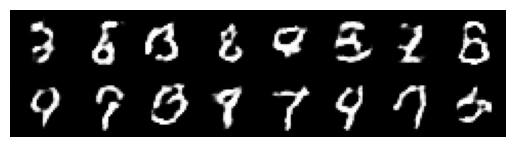

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def show_images(images):

    images = images.cpu().detach()
    images = images * 0.5 + 0.5
    grid = torchvision.utils.make_grid(images, nrow=8)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.axis('off')
    plt.show()

with torch.no_grad():
    z = torch.randn(16, z_dim, device=device)
    fake_images = Gnet(z)
    show_images(fake_images)